In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import sys,os,scipy,torch,warnings, copy
from scipy import signal
import mat73,math, copy
import neurokit2 as nk
%matplotlib inline

In [2]:
def mat2df():
    """
    Read .mat file from original MMECG dataset to a pandas dataframe.
    """
    # ID is the index of data files, Obj_ID is the index for actual person under test
    columnnames = ['ID', 'Obj_ID', 'RCG', 'ECG', 'posXYZ',
                   'gender', 'age', 'physistatus']
    df = pd.DataFrame(columns=columnnames)
    df.loc[0, columnnames] = [1, 2, 3, 4, 5, 6, 7, 8]

    for ID in range(1, 92):
        data = scipy.io.loadmat('/home/zhangyuanyuan/Dataset/data_MMECG/data_org/'+str(ID)+'.mat')
        Obj_ID= data['data'][0]['id'].squeeze()
        RCG = np.array([i for i in data['data'][0]['RCG']]).squeeze().transpose()
        ECG = np.array([i for i in data['data'][0]['ECG']]).squeeze()
        posXYZ = np.array([i for i in data['data'][0]['posXYZ']]).squeeze()
        gender = data['data'][0]['gender'].squeeze()
        age = data['data'][0]['age'].squeeze()
        physistatus = data['data'][0]['physistatus'].squeeze()

        df.loc[ID-1, columnnames] = [ID, int(Obj_ID),RCG,
                                    ECG, posXYZ, gender, int(age), physistatus]
    return df

df=mat2df() # read all the .mat file to dataframe
# Examples
df['RCG'][0] # trails for 50 points for sbject 0
df['posXYZ'][0] # xyz position for 50 points for sbject 0
df['ECG'][0] # ground truth ECG for sbject 0

array([-0.06437284, -0.06493853, -0.06562639, ...,  0.43761487,
        0.42550752,  0.41391745])

In [3]:
def down_sample(ecg, target_len=200):
    # using numpy
    ecg=np.interp(np.linspace(0, len(ecg), target_len), np.arange(len(ecg)), ecg)
    return ecg
# normlizaiton to [0,1]
def sst_norm_01(sst):
    for i in range(len(sst)):
        k=1/(np.max(sst[i])-np.min(sst[i]))
        sst[i] = 0+k*(sst[i]-np.min(sst[i]))
    return sst
def load_sst(sst_path):
    """
    load sst result generated from matlab
    """
    sst_plot = mat73.loadmat(sst_path, use_attrdict=True)
    # sst_plot = scipy.io.loadmat(sst_path, use_attrdict=True)
    sst_plot = np.flip(sst_plot['SST'], 1)
    return sst_plot
# normalize ECG to [0,1]
def normal_ecg(ECG):
    ECG = (ECG - np.min(ECG)) / (np.max(ECG) - np.min(ECG))
    return ECG
def normal_rcg(RCG):
    for i in range(len(RCG)):
        k=2/(np.max(RCG[i])-np.min(RCG[i]))
        RCG[i] = -1+k*(RCG[i]-np.min(RCG[i]))
    return RCG
def index_convert(index, freq_org=200, freq_desired=30):
    return int(index * freq_desired / freq_org)

In [4]:
ecg_seg_index_root = "/home/zhangyuanyuan/Dataset/data_MMECG/ecg_seg_index/"
sst_org_root = '/home/zhangyuanyuan/Dataset/data_MMECG/30Hz_half/'
path_des="/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/" # segment according to the step
path_des="/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/" # segment according to single cycle ECG
peak_root = "/home/zhangyuanyuan/Dataset/data_MMECG/peak_index/"

# creatre 91 folder with name '1' to '91'
for i in range(1,92):
    i_s=str(i)
    phy=str(df['physistatus'][i-1])[2:-2]
    obj=str(df['Obj_ID'][i-1])
    name = os.path.join(path_des, f'obj{obj}_{phy}_{i_s}_')
    if not os.path.exists(name):
        os.mkdir(name)
def sst_path_finder(index,path):
    for file in os.listdir(path):
        if re.search(f'_{index}_30Hz.mat', file):
            return file
def des_path_finder(index,path):
    for file in os.listdir(path):
        if re.search(f'_{index}_', file):
            return file
save_path=os.path.join(path_des, des_path_finder(2,path_des))
save_path

'/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/obj1_NB_2_'

In [5]:
obj_index = 1
point = 0
rcg = df['RCG'][obj_index-1][point]

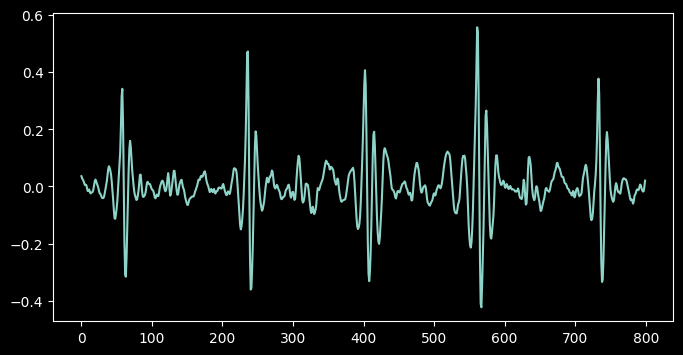

In [6]:
start = 5000
length = 800
plt.figure(figsize=(8, 4))
rcg_plot = rcg[start:start+length]
plt.plot(rcg_plot)
plt.style.use('default')

In [7]:
def add_gaussian(signal, snr_db):
    # 计算信号功率
    signal_power = np.mean(signal ** 2)
    
    # 计算噪声功率
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    
    # 生成高斯噪声
    noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
    
    return noise


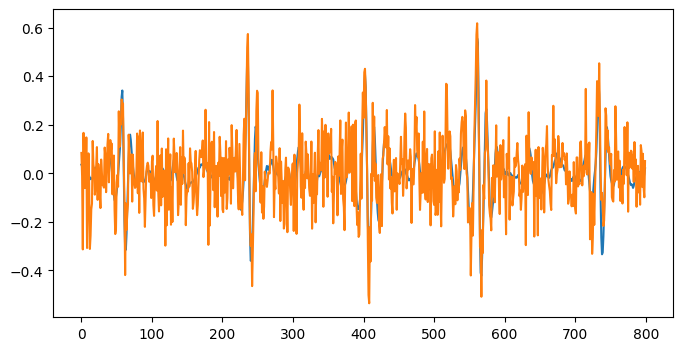

In [8]:
rcg_noise = add_gaussian(rcg_plot, snr_db = -1)
plt.figure(figsize=(8, 4))
plt.plot(rcg_plot)
plt.plot(rcg_plot+rcg_noise)


In [9]:
def add_gaussian_sst(sst, snr_db):
    for i in range(sst.shape[0]):
        # 计算信号功率
        signal_power = np.mean(sst[i] ** 2)
        
        # 计算噪声功率
        snr_linear = 10 ** (snr_db / 10)
        noise_power = signal_power / snr_linear
        
        # 生成高斯噪声
        noise = np.sqrt(noise_power) * np.random.randn(*sst[i].shape)
        sst[i] = sst[i] + noise
    return sst

Text(0.5, 1.0, 'STFT Magnitude')

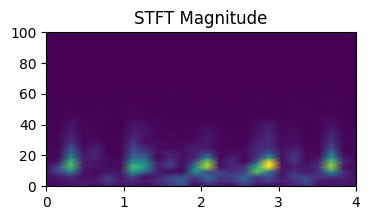

In [10]:
# stft of rcg_noise
rcg_noise = add_gaussian(rcg_plot, snr_db = 120)
sig = rcg_plot+rcg_noise
f, t, Zxx = signal.stft(sig, fs=200, nperseg=64)
plt.figure(figsize=(4, 2))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')

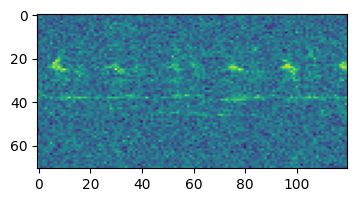

In [11]:
# check the alignment of sst and anchor mask
temp_id = 40
sst_seg=np.load(path_des+f"/obj29_SP_71_/sst_seg_{temp_id}.npy")
anchor_seg=np.load(path_des+f"/obj29_SP_71_/anchor_seg_{temp_id}.npy")
ecg_seg = np.load(path_des+f"/obj29_SP_71_/ecg_seg_{temp_id}.npy")
sst_noise = add_gaussian_sst(sst_seg, snr_db = -3)
plot = sst_noise
plt.figure(figsize=(4,2))
plt.imshow(plot[45], aspect='auto')


In [12]:
def add_gaussian_sst(sst, snr_db):
    for i in range(sst.shape[0]):
        # 计算信号功率
        signal_power = np.mean(sst[i] ** 2)
        
        # 计算噪声功率
        snr_linear = 10 ** (snr_db / 10)
        noise_power = signal_power / snr_linear
        
        # 生成高斯噪声
        noise = np.sqrt(noise_power) * np.random.randn(*sst[i].shape)
        sst[i] = sst[i] + noise
    return sst

In [20]:
# add abrupt noise with certqin length to sst
def add_abrupt_sst(sst, length = 101): # length 1 sec (length - 100)
    snr_db = -9
    length = length%100 * 30
    print(length)
    start = np.random.randint(0, sst.shape[1]-length) 
    for i in range(sst.shape[0]):
        # 计算信号功率
        signal_power = np.mean(sst[i][:,start:start+length] ** 2)
        
        # 计算噪声功率
        snr_linear = 10 ** (snr_db / 10)
        noise_power = signal_power / snr_linear
        
        # 生成高斯噪声
        noise = np.sqrt(noise_power) * np.random.randn(*sst[i][:,start:start+length].shape)
        sst[i][:,start:start+length] = sst[i][:,start:start+length] + noise
    return sst

60


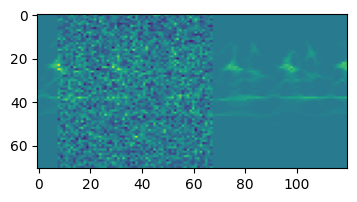

In [21]:
# check the alignment of sst and anchor mask
temp_id = 40
sst_seg=np.load(path_des+f"/obj29_SP_71_/sst_seg_{temp_id}.npy")
anchor_seg=np.load(path_des+f"/obj29_SP_71_/anchor_seg_{temp_id}.npy")
ecg_seg = np.load(path_des+f"/obj29_SP_71_/ecg_seg_{temp_id}.npy")
sst_noise = add_abrupt_sst(sst_seg,  102)
plot = sst_noise
plt.figure(figsize=(4,2))
plt.imshow(plot[45], aspect='auto')
